# Bayesian Model Averaging Linear Regression Pt. 2

In this notebook we continue the analysis using Bayeisan Model Averaging (BMA) for regression that we started in the first notebook in this series (https://www.kaggle.com/billbasener/bayesian-model-averaging-regression-tutorial).  In this second installment of the series, we use model averagining to examine prediction of baselball hitters' salaries based on their batting and fielding statistics.

In [75]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from itertools import combinations
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('seaborn-v0_8')
matplotlib.rcParams['figure.figsize'] = (12,6)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

Here is our class definition for Bayesian Model Averaging.  This is similar to the class provided in the first notebook on BMA with the following modifications:
1. We added a "Verbose" keyward argument that can be used to suppress the output of models and likelihoods while the code is running.
2. We use the Python library mpmath (http://mpmath.org/) for arbitrary floating point precision computations.  This is important because our likelihoods are very small, and the computations with Bayes theorem result in zeros and NaNs using normal float precision.
3. We add a .predict() method that uses the BMA averaged coefficients to make predictions.  This method functions like .predict() in the statsmodels OLS.
4. We added a sampling method known as "Occam's window" which is much faster than running all regression models.  Our implementation of Occam's window rejects models that have a likelihood that is 1/20 as high as the most likely model, and only considers new models that are constructed by adding a new regressor variable to a perviously non-rejected model.

In [76]:
from mpmath import mp
mp.dps = 50
class BMA:
    
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.coefficients_mp = mp.zeros(self.nCols,1)
        self.coefficients = np.zeros(self.nCols)
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_next = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
            if num_elements == 1:
                Models_current = Models_next
                Models_previous = []
            else:
                idx_keep = np.zeros(len(Models_next))
                for M_new,idx in zip(Models_next,range(len(Models_next))):
                    for M_good in Models_previous:
                        if(all(x in M_new for x in M_good)):
                            idx_keep[idx] = 1
                            break
                        else:
                            pass
                Models_current = np.asarray(Models_next)[np.where(idx_keep==1)].tolist()
                Models_previous = []
                        
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]
                model_regr = OLS(self.y, model_X).fit()
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                    
                if (model_likelihood > max_likelihood/20):
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                    
                    # Add this likelihood to the running tally of likelihoods.
                    likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)

                    # Add this likelihood (times the priors) to the running tally
                    # of likelihoods for each variable in the model.
                    for idx, i in zip(model_index_set, range(num_elements)):
                        self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=1000)
                        self.coefficients_mp[idx] = mp.fadd(self.coefficients_mp[idx], model_regr.params[i]*model_likelihood, prec=1000)
                    Models_previous.append(model_index_set) # add this model to the list of good models
                    max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                else:
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"rejected by Occam's window")
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            self.coefficients[idx] = mp.fdiv(self.coefficients_mp[idx],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
    def predict(self, data):
        data = np.asarray(data)
        try:
            result = np.dot(self.coefficients,data)
        except:
            result = np.dot(self.coefficients,data.T)
        return result  
        
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df    

In [77]:
df = pd.read_csv('Guber1999data.csv')
df.head()
X = df[["Spend", "StuTeaRat", "Salary", "PrcntTake"]]
y = df["SATT"]
result = BMA(y, add_constant(X), Verbose=True).fit()

Computing BMA for models of size:  1
Model Variables: (0,) likelihood= 7.1937803550309139034407543025958410374282235907823e-126
Model Variables: (1,) rejected by Occam's window
Model Variables: (2,) rejected by Occam's window
Model Variables: (3,) rejected by Occam's window
Model Variables: (4,) rejected by Occam's window
Computing BMA for models of size:  2
Model Variables: [0, 1] likelihood= 5.0802683000630061369353486206961250578401690985192e-125
Model Variables: [0, 2] rejected by Occam's window
Model Variables: [0, 3] likelihood= 2.199519070505456350276346975345801946484185315059e-124
Model Variables: [0, 4] likelihood= 6.2652651451285236026558651171157093900079084428567e-110
Computing BMA for models of size:  3
Model Variables: [0, 1, 2] rejected by Occam's window
Model Variables: [0, 1, 3] rejected by Occam's window
Model Variables: [0, 1, 4] likelihood= 5.551463674832322882273770709166504383852797598525e-109
Model Variables: [0, 2, 3] rejected by Occam's window
Model Variables:

In [78]:
result.summary()

,Variable Name,Probability,Avg. Coefficient
0,const,1.0,1014.722502
1,Spend,0.694907,8.470464
2,StuTeaRat,0.281636,-0.978594
3,Salary,0.285712,0.490107
4,PrcntTake,1.0,-2.820532


In [79]:
Hitters = pd.read_csv('Hitters.csv').dropna() 
# read data set and drop missing values 
#Hitters.info()


y = Hitters.Salary
# Drop Salary (target) and columns for which we created dummy variables
X_ = Hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
#X.info()

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
...     add_constant(X), y, test_size=0.33, random_state=42)

In [81]:
reg_OLS = OLS(y_train, X_train).fit()
reg_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     14.18
Date:                Thu, 16 Mar 2023   Prob (F-statistic):           3.86e-25
Time:                        13:35:05   Log-Likelihood:                -1228.2
No. Observations:                 176   AIC:                             2496.
Df Residuals:                     156   BIC:                             2560.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -54.9742    100.425     -0.547      0.585    -253.343     143.394
AtBat          -1.3429      0.735     -1.827      0.070      -2.795       0.109
Hits            8.1584      2.513      3.246      0.001       3.194      13.123
HmRun          10.3561      7.003      1.479      0.141      -3.477      24.189
Runs           -3.1891      3.169     -1.006      0.316      -9.449       3.070
RBI            -3.8630      2.845     -1.358      0.176      -9.483       1.757
Walks           4.2366      2.001      2.118      0.036       0.285       8.189
Years          20.4982     13.778      1.488      0.139      -6.718      47.715
CAtBat         -0.3251      0.160     -2.027      0.044      -0.642      -0.008
CHits           0.3716      0.782      0.475      0.635      -1.173       1.916
CHmRun          0.4705      1.987      0.237      0.813      -3.455       4.396
CRuns           1.8504      0.840      2.202      0.029       0.190       3.511
CRBI            0.5231      0.838      0.624      0.533      -1.132       2.178
CWalks         -0.8135      0.370     -2.201      0.029      -1.544      -0.083
PutOuts         0.2814      0.082      3.423      0.001       0.119       0.444
Assists         0.3392      0.240      1.413      0.160      -0.135       0.813
Errors         -1.2568      4.620     -0.272      0.786     -10.382       7.868
League_N       95.4437     86.549      1.103      0.272     -75.516     266.403
Division_W    -90.8954     43.760     -2.077      0.039    -177.333      -4.457
NewLeague_N   -11.4658     85.292     -0.134      0.893    -179.943     157.011
==============================================================================
Omnibus:                       11.653   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               18.967
Skew:                           0.344   Prob(JB):                     7.61e-05
Kurtosis:                       4.454   Cond. No.                     2.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observe that there is a lot of uncertainty in the 95% confidence intervals above.**

In [82]:
reg_BMA = BMA(y_train, X_train, Verbose=False).fit()

In [83]:
reg_BMA.summary()

,Variable Name,Probability,Avg. Coefficient
0,const,0.029864,-2.077322
1,AtBat,0.853518,-1.253127
2,Hits,0.999958,6.925059
3,HmRun,0.058282,0.24622
4,Runs,0.023916,0.030161
5,RBI,0.024391,0.009585
6,Walks,0.083127,0.205394
7,Years,0.018314,-0.015495
8,CAtBat,0.436963,-0.073457
9,CHits,0.136156,0.063604


In [84]:
pred_reg_BMA = reg_BMA.predict(X_test)
pred_reg_OLS = reg_OLS.predict(X_test)
pred_reg_OLS = np.asarray(pred_reg_OLS)

In [85]:
# Compute accuracy
errors_BMA = np.asarray(y_test)-pred_reg_BMA
errors_OLS = np.asarray(y_test)-pred_reg_OLS
RMSE_BMA = np.sqrt(np.dot(errors_BMA,errors_BMA)/len(y_test))
RMSE_OLS = np.sqrt(np.dot(errors_OLS,errors_OLS)/len(y_test))
print('Root Mean Squared Error for BMA: ',RMSE_BMA)
print('Root Mean Squared Error for OLS: ',RMSE_OLS)

Root Mean Squared Error for BMA:  396.25751499094815
Root Mean Squared Error for OLS:  397.4611760850021


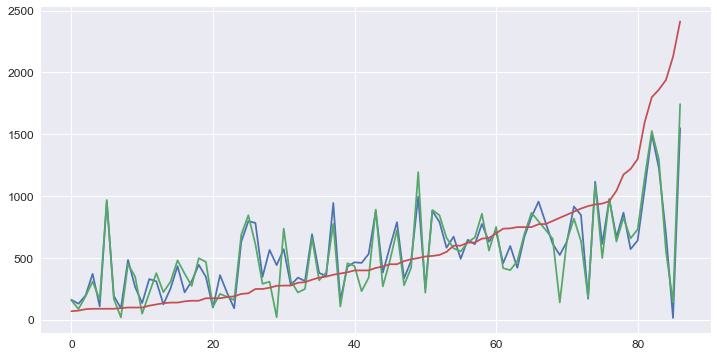

In [86]:
idx_sort = np.argsort(np.asarray(y_test))
import matplotlib.pyplot as plt
plt.plot(pred_reg_BMA[idx_sort])
plt.plot(pred_reg_OLS[idx_sort])
plt.plot(np.asarray(y_test)[idx_sort])

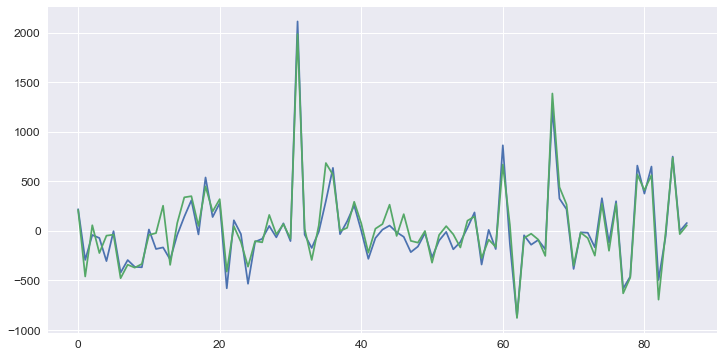

In [87]:
import matplotlib.pyplot as plt
plt.plot(errors_BMA)
plt.plot(errors_OLS)

In [88]:
num_iters = 50
RMSE_BMA_all = np.zeros(num_iters)
RMSE_OLS_all = np.zeros(num_iters)
RMSE_BMA_all_mean = np.zeros(num_iters)
RMSE_OLS_all_mean = np.zeros(num_iters)

for i in range(num_iters):
    X_train, X_test, y_train, y_test = train_test_split(add_constant(X), y, random_state=i, test_size=0.33)
    # fit the models to the training data
    reg_BMA = BMA(y_train, X_train, Verbose=False).fit()
    reg_OLS = OLS(y_train, X_train).fit()
    # predict on the test data
    pred_reg_BMA = reg_BMA.predict(X_test)
    pred_reg_OLS = reg_OLS.predict(X_test)
    pred_reg_OLS = np.asarray(pred_reg_OLS)
    # Compute Root Mean Squared Error
    errors_BMA = np.asarray(y_test)-pred_reg_BMA
    errors_OLS = np.asarray(y_test)-pred_reg_OLS
    RMSE_BMA = np.sqrt(np.dot(errors_BMA,errors_BMA)/len(y_test))
    RMSE_OLS = np.sqrt(np.dot(errors_OLS,errors_OLS)/len(y_test))
    print('Root Mean Squared Error for BMA: ',RMSE_BMA)
    print('Root Mean Squared Error for OLS: ',RMSE_OLS)
    RMSE_BMA_all[i] = RMSE_BMA
    RMSE_OLS_all[i] = RMSE_OLS
    RMSE_BMA_all_mean[i] = np.sum(RMSE_BMA_all)/(i+1)
    RMSE_OLS_all_mean[i] = np.sum(RMSE_OLS_all)/(i+1)
    print('(Mean) Root Mean Squared Error for BMA: ',RMSE_BMA_all_mean[i])
    print('(Mean) Root Mean Squared Error for OLS: ',RMSE_OLS_all_mean[i])
    
print('(Mean) Root Mean Squared Error for BMA: ',np.mean(RMSE_BMA_all))
print('(Mean) Root Mean Squared Error for OLS: ',np.mean(RMSE_BMA_all))

Root Mean Squared Error for BMA:  391.3536344252133
Root Mean Squared Error for OLS:  374.83317817256494
(Mean) Root Mean Squared Error for BMA:  391.3536344252133
(Mean) Root Mean Squared Error for OLS:  374.83317817256494
Root Mean Squared Error for BMA:  355.03617522548757
Root Mean Squared Error for OLS:  361.4929023370328
(Mean) Root Mean Squared Error for BMA:  373.1949048253504
(Mean) Root Mean Squared Error for OLS:  368.16304025479883
Root Mean Squared Error for BMA:  420.52248540568047
Root Mean Squared Error for OLS:  417.73944690875015
(Mean) Root Mean Squared Error for BMA:  388.97076501879377
(Mean) Root Mean Squared Error for OLS:  384.68850913944925
Root Mean Squared Error for BMA:  346.8864308903786
Root Mean Squared Error for OLS:  360.0630692660719
(Mean) Root Mean Squared Error for BMA:  378.44968148669
(Mean) Root Mean Squared Error for OLS:  378.53214917110495
Root Mean Squared Error for BMA:  425.29491787074693
Root Mean Squared Error for OLS:  404.98860842080154

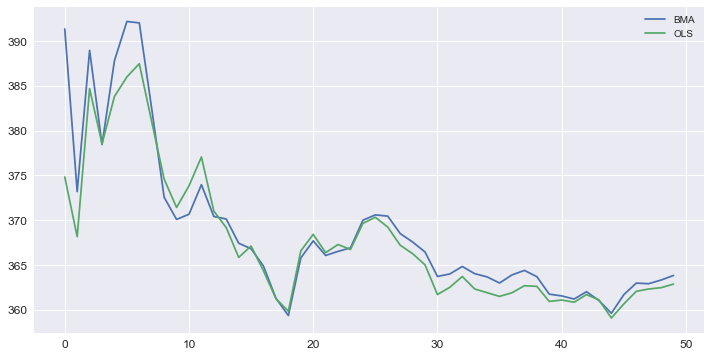

In [89]:
plt.plot(RMSE_BMA_all_mean, label='BMA')
plt.plot(RMSE_OLS_all_mean, label='OLS')
plt.legend();

# Crime and Punishment Data

See: https://sites.stat.washington.edu/raftery/Research/PDF/rmh1997.pdf

In [90]:
crime = pd.read_csv('uscrime.csv').dropna() 
crime.head()

,Percent Males 14-24,Southern State,Mean Years Education,Police Expediture 1960,Police Expediture 1959,Labor Force Rate,Males per 100 Females,State Polutation,Non-white people per 1000,Unemployment rate urban males age 14-24,Unemployment rate urban males age 35-39,Wealth,Income Inequality,Probability of Imprisonment,Average Jail Sentence Time,Crime
0,15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
1,14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
2,14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
3,13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
4,14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234


In [91]:
crime = pd.read_csv('uscrime.csv').dropna() 

# seperate into X and y data
y = crime.Crime
# Drop Salary (target) and columns for which we created dummy variables
X = crime.drop(['Crime'], axis=1).astype('float64')

In [92]:
reg_OLS = OLS(y, X).fit()
reg_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Crime   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              47.64
Date:                Thu, 16 Mar 2023   Prob (F-statistic):                    1.36e-17
Time:                        13:46:58   Log-Likelihood:                         -316.51
No. Observations:                  47   AIC:                                      663.0
Df Residuals:                      32   BIC:                                      690.8
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Percent Males 14-24                        60.7745     48.422      1.255      0.219     -37.859     159.408
Southern State                             43.5826    174.772      0.249      0.805    -312.416     399.581
Mean Years Education                      155.8130     72.476      2.150      0.039       8.184     303.442
Police Expediture 1960                    309.7168    119.383      2.594      0.014      66.542     552.891
Police Expediture 1959                   -221.7971    133.770     -1.658      0.107    -494.278      50.684
Labor Force Rate                           41.7616   1718.451      0.024      0.981   -3458.608    3542.131
Males per 100 Females                     -29.9713     18.575     -1.613      0.116     -67.808       7.866
State Polutation                           -1.9212      1.472     -1.305      0.201      -4.920       1.078
Non-white people per 1000                   5.7400      7.627      0.753      0.457      -9.796      21.276
Unemployment rate urban males age 14-24 -1883.1732   4801.344     -0.392      0.697   -1.17e+04    7896.844
Unemployment rate urban males age 35-39    98.3535     94.510      1.041      0.306     -94.157     290.864
Wealth                                      0.0117      0.119      0.098      0.923      -0.231       0.254
Income Inequality                          51.0219     26.038      1.960      0.059      -2.015     104.059
Probability of Imprisonment             -7804.0319   2507.276     -3.113      0.004   -1.29e+04   -2696.877
Average Jail Sentence Time                -13.2256      7.850     -1.685      0.102     -29.216       2.765
==============================================================================
Omnibus:                        5.446   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                7.334
Skew:                          -0.019   Prob(JB):                       0.0256
Kurtosis:                       4.935   Cond. No.                     7.25e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [93]:
crime_BMA = BMA(y, X, Verbose=False).fit()

In [94]:
crime_BMA.summary()

,Variable Name,Probability,Avg. Coefficient
0,Percent Males 14-24,0.122636,3.234399
1,Southern State,0.174181,28.205366
2,Mean Years Education,0.156533,9.147661
3,Police Expediture 1960,0.917596,115.678594
4,Police Expediture 1959,0.235766,-15.286638
5,Labor Force Rate,0.095788,-3.533189
6,Males per 100 Females,0.254227,-2.580431
7,State Polutation,0.222815,-0.457348
8,Non-white people per 1000,0.16615,1.13987
9,Unemployment rate urban males age 14-24,0.065723,-87.417985


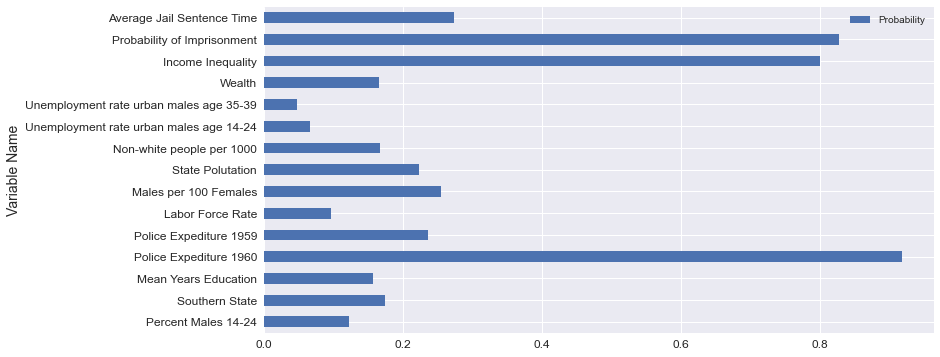

In [95]:
# Create a bar plot with the probaiblities
crime_BMA.summary().plot.barh(x='Variable Name', y='Probability', rot=0);

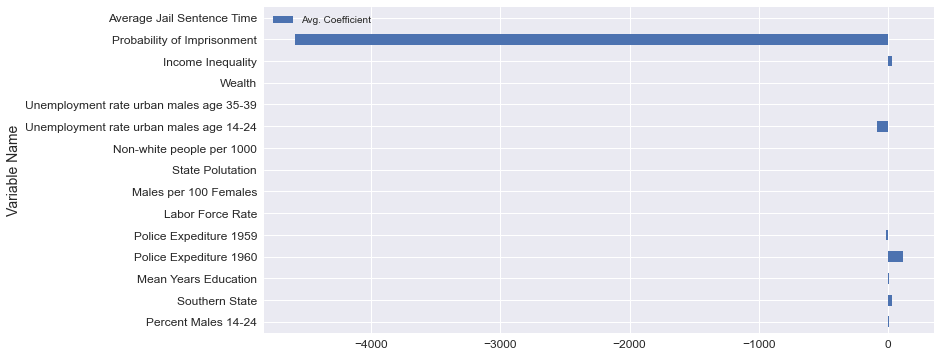

In [96]:
# Create a bar plot with the coefficients
crime_BMA.summary().plot.barh(x='Variable Name', y='Avg. Coefficient', rot=0);